In [2]:
!nvidia-smi
!pip install -q tensorflow-gpu==2.0.0-alpha0

Sat May 18 17:55:30 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.color import rgb2gray
import os
from os import listdir
from os.path import isfile, join
import random 
import cv2
from sklearn.preprocessing import normalize
from google.cloud import bigquery
from google.colab import auth
import zipfile
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Activation

## Mount Drive for Data


In [3]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/Colab Notebooks/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### UNZIP THE DATA IF IN ZIP FORMAT

In [0]:
# data = "."
# data_zip = "./data.zip"
# zip_ref = zipfile.ZipFile(data_zip, "r")
# zip_ref.extractall(data)
# zip_ref.close()

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from keras.utils import *

TARGET_SHAPE = 299 
BATCH_SIZE = 32

def get_image_gen(level):
    train_dir = 'data/train/z{}'.format(level)
    val_dir = 'data/val/z{}'.format(level)
    print('Train dir: ', train_dir)
    print('Val dir: ', val_dir)

    image_gen_train = ImageDataGenerator(rescale=1./255,
                                         horizontal_flip=True,
                                         vertical_flip=True)
#                                          rotation_range=90)
    image_gen_val = ImageDataGenerator(rescale=1./255)

    train_data_gen = image_gen_train.flow_from_directory(
        batch_size=BATCH_SIZE,
        directory=train_dir,
        shuffle=True,
        target_size=(TARGET_SHAPE,TARGET_SHAPE),
        class_mode='binary')

    # Validation data should not be augmented!
    val_data_gen = image_gen_val.flow_from_directory(
        batch_size=BATCH_SIZE, 
        directory=val_dir, 
        target_size=(TARGET_SHAPE, TARGET_SHAPE),
        class_mode='binary')

    weights = class_weight.compute_class_weight('balanced',
                                                np.unique(train_data_gen.classes), 
                                                train_data_gen.classes)
    return train_data_gen, val_data_gen, {0: weights[0], 1: weights[1]}

# Zoom Level 2

In [10]:
!pwd
print('Num tumor: ')
!find data/train/z2/tumor -type f | grep jpg | wc -l
print('Num non-tumor: ')
!find data/train/z2/no_tumor -type f | grep jpg | wc -l

/content
Num tumor: 
find: ‘data/train/z2/tumor’: No such file or directory
0
Num non-tumor: 
find: ‘data/train/z2/no_tumor’: No such file or directory
0


In [15]:
train_data_gen_z2, val_data_gen_z2, class_weights_z2 = get_image_gen(2)

Train dir:  data/train/z2
Val dir:  data/val/z2
Found 953 images belonging to 2 classes.
Found 1238 images belonging to 2 classes.


In [0]:
total_train_z2 = train_data_gen_z2.n
total_val_z2 = val_data_gen_z2.n

### Balancing data with Class Weighting

In [7]:
print(class_weights_z2)
print('Percent no tumor for Training: {}'.format((np.bincount(train_data_gen_z2.classes)/train_data_gen_z2.n)[0]))
print('Percent no tumor for Validation: {}'.format((np.bincount(val_data_gen_z2.classes)/val_data_gen_z2.n)[0]))

{0: 0.9989517819706499, 1: 1.0010504201680672}
Percent no tumor for Training: 0.5005246589716684
Percent no tumor for Validation: 0.622778675282714


### Pre-trained Inception Model

In [15]:
conv_base1 = InceptionV3(weights='imagenet',include_top=False, input_shape=(299, 299, 3))
conv_base1.trainable = False

model_z2 = Sequential()
model_z2.add(conv_base1)
model_z2.add(Flatten())
model_z2.add(Dense(32, activation='relu'))
model_z2.add(Dense(1, activation='sigmoid'))
my_model_z2.summary()

87916544/87910968 [==============================] - 8s 0us/step


In [11]:
EPOCHS = 20

model_z2.compile(loss='binary_crossentropy', 
                 optimizer='adam', 
                 metrics=['acc'])

# Now is a good time for a cup of coffee
history_z2 = model_z2.fit_generator(
      train_data_gen_z2,
      steps_per_epoch=int(np.ceil(total_train_z2 / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen_z2,
      validation_steps=int(np.ceil(total_val_z2 / float(BATCH_SIZE))),
#       class_weight=class_weights_z2,
      verbose=2)

Epoch 1/20
30/30 - 599s - loss: 2.2648 - acc: 0.7125 - val_loss: 0.6032 - val_acc: 0.5880
Epoch 2/20
30/30 - 12s - loss: 0.4824 - acc: 0.7870 - val_loss: 0.5416 - val_acc: 0.6551
Epoch 3/20
30/30 - 12s - loss: 0.3653 - acc: 0.8478 - val_loss: 0.4486 - val_acc: 0.7754
Epoch 4/20
30/30 - 12s - loss: 0.4218 - acc: 0.8164 - val_loss: 0.4130 - val_acc: 0.8312
Epoch 5/20
30/30 - 12s - loss: 0.3299 - acc: 0.8510 - val_loss: 0.3750 - val_acc: 0.8433
Epoch 6/20
30/30 - 12s - loss: 0.2692 - acc: 0.8804 - val_loss: 0.2740 - val_acc: 0.9023
Epoch 7/20
30/30 - 12s - loss: 0.2897 - acc: 0.8856 - val_loss: 0.3216 - val_acc: 0.8853
Epoch 8/20
30/30 - 12s - loss: 0.2285 - acc: 0.8961 - val_loss: 0.3389 - val_acc: 0.8813
Epoch 9/20
30/30 - 13s - loss: 0.2244 - acc: 0.8919 - val_loss: 0.3694 - val_acc: 0.8554
Epoch 10/20
30/30 - 12s - loss: 0.2316 - acc: 0.9014 - val_loss: 0.3798 - val_acc: 0.8627
Epoch 11/20
30/30 - 12s - loss: 0.2021 - acc: 0.9213 - val_loss: 0.3037 - val_acc: 0.8740
Epoch 12/20
30/30 

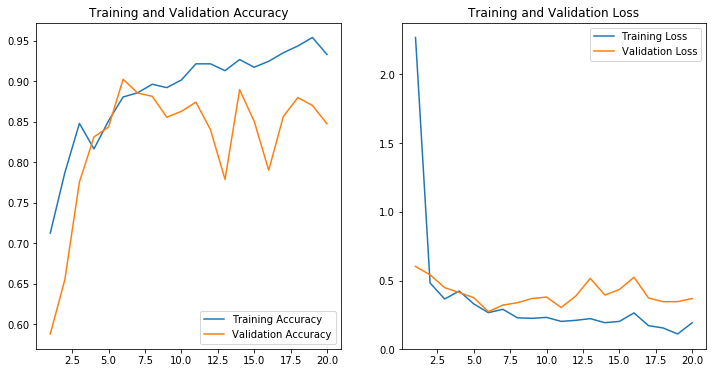

In [12]:
acc = history_z2.history['acc']
val_acc = history_z2.history['val_acc']

loss = history_z2.history['loss']
val_loss = history_z2.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
# save model and history object
import json

model_z2.save('/content/gdrive/My Drive/Colab Notebooks/z2_inception_20_epoch.h5')
history_z2_dict = history_z2.history
with open('z2_inception_20_epoch_history.txt', 'w') as outfile:  
    json.dump(str(history_z2_dict), outfile)

### Own Model

In [17]:
my_model_z2 = Sequential()
my_model_z2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
my_model_z2.add(MaxPooling2D((2, 2)))
my_model_z2.add(Conv2D(64, (3, 3), activation='relu'))
my_model_z2.add(MaxPooling2D((2, 2)))
my_model_z2.add(Conv2D(128, (3, 3), activation='relu'))
my_model_z2.add(MaxPooling2D((2, 2)))
my_model_z2.add(Conv2D(128, (3, 3), activation='relu'))
my_model_z2.add(MaxPooling2D((2, 2)))
my_model_z2.add(Flatten())
my_model_z2.add(Dense(128, activation='relu'))
my_model_z2.add(Dropout(0.25))
my_model_z2.add(Dense(128, activation='relu'))
# my_model_z2.add(Dense(512, activation='relu'))
my_model_z2.add(Dense(1, activation='sigmoid'))
my_model_z2.summary()

# my_model_z2 = Sequential() 
# my_model_z2.add(Conv2D(filters=64, kernel_size=2, activation='relu', input_shape=(299, 299, 3)))
# my_model_z2.add(MaxPooling2D(pool_size=2))
# my_model_z2.add(Dropout(0.3))
# my_model_z2.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
# my_model_z2.add(MaxPooling2D(pool_size=2))
# my_model_z2.add(Dropout(0.3))
# my_model_z2.add(Flatten())
# my_model_z2.add(Dense(256, activation='relu'))
# my_model_z2.add(Dropout(0.5))
# my_model_z2.add(Dense(2, activation='softmax'))
# my_model_z2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 148, 148, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 128)       1

In [18]:
EPOCHS = 15

my_model_z2.compile(loss='binary_crossentropy', 
                    optimizer='adam', 
                    metrics=['acc'])

# Now is a good time for a cup of coffee
my_history_z2 = my_model_z2.fit_generator(
      train_data_gen_z2,
      steps_per_epoch=int(np.ceil(total_train_z2 / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen_z2,
      validation_steps=int(np.ceil(total_val_z2 / float(BATCH_SIZE))),
#       class_weight=class_weights_z2,
      verbose=2)

Epoch 1/15
30/30 - 856s - loss: 0.6594 - acc: 0.6422 - val_loss: 0.5033 - val_acc: 0.6858
Epoch 2/15
30/30 - 10s - loss: 0.5212 - acc: 0.7492 - val_loss: 0.3439 - val_acc: 0.8045
Epoch 3/15
30/30 - 10s - loss: 0.4735 - acc: 0.7954 - val_loss: 0.4055 - val_acc: 0.7819
Epoch 4/15
30/30 - 10s - loss: 0.3845 - acc: 0.8332 - val_loss: 0.2185 - val_acc: 0.9467
Epoch 5/15
30/30 - 10s - loss: 0.3506 - acc: 0.8688 - val_loss: 0.2715 - val_acc: 0.8619
Epoch 6/15
30/30 - 10s - loss: 0.3137 - acc: 0.8730 - val_loss: 0.6859 - val_acc: 0.6438
Epoch 7/15
30/30 - 10s - loss: 0.3174 - acc: 0.8741 - val_loss: 0.3246 - val_acc: 0.8263
Epoch 8/15
30/30 - 10s - loss: 0.2862 - acc: 0.8867 - val_loss: 0.1431 - val_acc: 0.9742
Epoch 9/15
30/30 - 11s - loss: 0.4876 - acc: 0.7870 - val_loss: 0.5457 - val_acc: 0.6777
Epoch 10/15
30/30 - 11s - loss: 0.3744 - acc: 0.8468 - val_loss: 0.2251 - val_acc: 0.9136
Epoch 11/15
30/30 - 10s - loss: 0.3120 - acc: 0.8709 - val_loss: 0.2204 - val_acc: 0.8885
Epoch 12/15
30/30 

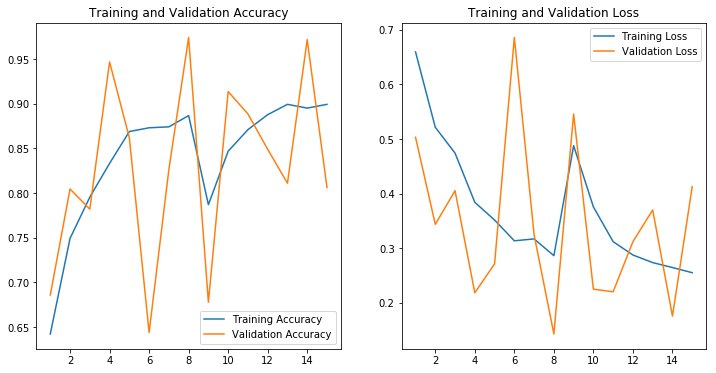

In [19]:
acc = my_history_z2.history['acc']
val_acc = my_history_z2.history['val_acc']

loss = my_history_z2.history['loss']
val_loss = my_history_z2.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
# save model and history object
import json

my_model_z2.save('/content/gdrive/My Drive/Colab Notebooks/z2_custom_15_epoch.h5')
my_history_z2_dict = my_history_z2.history
with open('z2_custom_15_epoch_history.txt', 'w') as outfile:  
    json.dump(str(my_history_z2_dict), outfile)

# Zoom Level 3

In [17]:
train_data_gen_z3, val_data_gen_z3, class_weights_z3 = get_image_gen(3)

total_train_z3 = train_data_gen_z3.n
total_val_z3 = val_data_gen_z3.n

Train dir:  data/train/z3
Val dir:  data/val/z3
Found 1170 images belonging to 2 classes.
Found 739 images belonging to 2 classes.


In [0]:
my_model_z3 = Sequential()
my_model_z3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
my_model_z3.add(MaxPooling2D((2, 2)))
my_model_z3.add(Conv2D(64, (3, 3), activation='relu'))
my_model_z3.add(MaxPooling2D((2, 2)))
my_model_z3.add(Conv2D(128, (3, 3), activation='relu'))
my_model_z3.add(MaxPooling2D((2, 2)))
my_model_z3.add(Conv2D(128, (3, 3), activation='relu'))
my_model_z3.add(MaxPooling2D((2, 2)))
my_model_z3.add(Flatten())
# my_model_z3.add(Dense(512, activation='relu'))
my_model_z3.add(Dense(1, activation='sigmoid'))

In [0]:
EPOCHS = 15

my_model_z3.compile(loss='binary_crossentropy', 
                    optimizer='adam', 
                    metrics=['acc'])

# Now is a good time for a cup of coffee
my_history_z3 = my_model_z3.fit_generator(
      train_data_gen_z3,
      steps_per_epoch=int(np.ceil(total_train_z3 / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=val_data_gen_z3,
      validation_steps=int(np.ceil(total_val_z3 / float(BATCH_SIZE))),
#       class_weight=class_weights_z3,
      verbose=2)

In [0]:
acc = my_history_z3.history['acc']
val_acc = my_history_z3.history['val_acc']

loss = my_history_z3.history['loss']
val_loss = my_history_z3.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
# save model and history object
import json

my_model_z3.save('/content/gdrive/My Drive/Colab Notebooks/z3_custom_15_epoch.h5')
my_history_z3_dict = my_history_z3.history
with open('z3_custom_15_epoch_history.txt', 'w') as outfile:  
    json.dump(str(my_history_z3_dict), outfile)

# Combining 2 Levels - Inception (Zoom 2) and Custom CNN (Zoom 3)

In [0]:
from tensorflow.keras.layers import Concatenate
EPOCHS = 2

# first = Sequential()
# first.add(Dense(1, input_shape=(2,), activation='sigmoid'))
# second = Sequential()
# second.add(Dense(1, input_shape=(1,), activation='sigmoid'))
# third = Sequential()
# third.add(Dense(1, input_shape=(1,), activation='sigmoid'))

# merged = Concatenate([first, second])
merged = Concatenate([model_z2, my_model_z3])

result = Sequential()
result.add(Concatenate([model_z2, my_model_z3]))
result.add(Dense(1, activation='sigmoid'))
result.summary()
# result.compile(loss='binary_crossentropy', 
#                     optimizer='adam', 
#                     metrics=['acc'])

combined_history_z3 = result.fit_generator([train_data_gen_z2, train_data_gen_z3], 
#                                            steps_per_epoch=int(np.ceil(total_train_z3 / float(BATCH_SIZE))),
                                           epochs=EPOCHS,
                                           validation_data=[val_data_gen_z2, val_data_gen_z3],
#                                            validation_steps=int(np.ceil(total_val_z3 / float(BATCH_SIZE))),
                                           verbose=2)

## Plotting Confusion Matrix

In [0]:
# this code was taken from 
# https://scikit-learn.org/stable/auto_examples/model_selection/
# plot_confusion_matrix.html#
# sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

import itertools
from sklearn.metrics import classification_report, confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Confusion Matrix for Transfer Learning Model (Inception) for Zoom Level 2

In [0]:
y_pred = model_z2.predict_classes(val_data_gen_z2)
class_names = ['No Tumor', 'Tumor']

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_data_gen_z2.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, 
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Confusion Matrix for Custom Model for Zoom Level 2

In [0]:
y_pred = my_model_z2.predict_classes(val_data_gen_z2)
class_names = ['No Tumor', 'Tumor']

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_data_gen_z2.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

## Confusion Matrix for Custom Model for Zoom Level 3

In [0]:
y_pred = my_model_z3.predict_classes(val_data_gen_z3)
class_names = ['No Tumor', 'Tumor']

# Compute confusion matrix
cnf_matrix = confusion_matrix(val_data_gen_z3.classes, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()